###  Activity 1: All Possible Regressions

This is a quick assignment.  I would expect it to only take a couple of hours to complete. The start of this notebook develops the example.  You will then parallelize the exammple using `joblib`. 

Run this on a machine that has at least 4 cores. Typically this is your laptop. The ugrad machines are also OK. Google Colab is not adequate. Fill out the requested cells toward the bottom of the notebook.

**Due date**: Wednesday September 11, 2024, 9:00 pm EDT.

**Instructions for Submission**: Submit via Gradescope.

#### Preparing the Environment

You will need a couple of packages installed to make this work.  Stop your instance of jupyter lab and then run

```
conda install pandas pandoc
jupyter lab
```
At this point, you should be ready to go.

#### Example code

This is a Python reimplementation of the Section 3.4. in _Matloff_, Parallel Computing for Data Science. It is based on data from https://www.kaggle.com/divan0/multiple-linear-regression. The notebook asks the question what combination of variables best predict the price of a house.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

#importing dataset using panda
dataset = pd.read_csv('ebook/data/kc_house_data.csv') #NOTE: used to be: ../data/kc_house_data.csv
#to see what my dataset is comprised of
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
#dropping the id and date column
dataset = dataset.drop(['id','date'], axis=1)

# clean out NaN and inf values
dataset = dataset[~dataset.isin([np.nan, np.inf, -np.inf]).any(axis=1)] #NOTE: had to change to axis = 1

Let's first do a simple regression. How does square footage predict price? 

In [4]:
from sklearn.linear_model import LinearRegression

X = np.array(dataset.sqft_living)
Y = np.array(dataset.price)

# shape X into matrix of a single column
X = X.reshape((X.shape[0],1))

model = LinearRegression()
model.fit(X,Y)
r_sq = model.score(X,Y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.4928817196006995


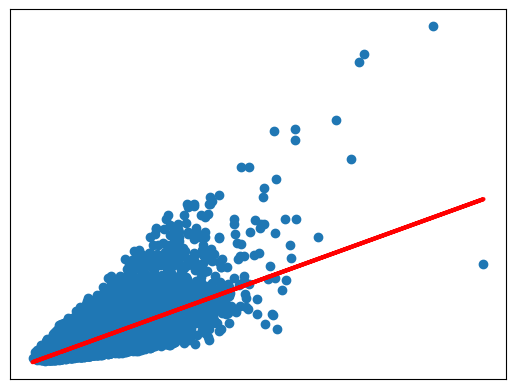

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

# scatter data
plt.plot(X,Y,'o')
# best fit line
y_pred = model.intercept_ + model.coef_ * X
plt.plot(X, y_pred, color='red', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

We see that there is a strong correlation between square footage and house price.  The coefficient of determination measures the strength of the correlation and varies between 0 (no correlation) and 1.0 (perfectly correlated).

### Multiple Linear Regression

Adding more variables often improves the score.

In [6]:
X = np.array(dataset[['sqft_living','condition','yr_built']])
Y = np.array(dataset.price)

# shape X into matrix of a single column
X = X.reshape((X.shape[0],3))

model = LinearRegression()
model.fit(X,Y)
r_sq = model.score(X,Y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.5249639858277426


but some variables are confounding

In [7]:
X = np.array(dataset[['zipcode','floors','waterfront']])
Y = np.array(dataset.price)

# shape X into matrix of a single column
X = X.reshape((X.shape[0],3))

model = LinearRegression()
model.fit(X,Y)
r_sq = model.score(X,Y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.1358874997770878


This leads to a first parallel program.  What are the right set of variables? A brute force approach called _All Possible Regressions_ examines all combinations. So, let's build a big matrix that and we will regress on subsets.  We will look at all combinations of 1, 2, or 3 variables.

In [8]:
from itertools import combinations, chain

Y = np.array(dataset.price)
X = np.array(dataset.drop(['price'], axis=1))

## Let's choose all combinations of 1, 2, and 3 columns.
col_idxs = np.array(range(X.shape[1]))
combos = list(chain(combinations(col_idxs, 1), combinations(col_idxs, 2), combinations(col_idxs, 3)))

In [9]:
model = LinearRegression()

# do in a for loop (dumbest way)
r_sq_best = 0.0
for combo in combos:
    Xp = X[:,combo]
    model = model.fit(Xp,Y)
    r_sq = model.score(Xp,Y)
    if r_sq > r_sq_best:
        r_sq_best = r_sq
        combo_best = combo
    
print(r_sq_best, combo_best)

0.6095149101819037 (2, 6, 14)


The outcome is kind of crazy. The fields are `sqft-living`, `view`, and `latitude`. Latitude is probably a somewhat accurate proxy for wealth in this area, e.g. N of town richer than south of town. But, this is the kind of outcome that would not translate to other regions, i.e. is likely specific to this data.  _Neat_.

Back to performance.

In [10]:
%%timeit
model = LinearRegression()

r_sq_best = 0.0
for combo in combos:
    Xp = X[:,combo]
    model = model.fit(Xp,Y)
    r_sq = model.score(Xp,Y)
    if r_sq > r_sq_best:
        r_sq_best = r_sq
        combo_best = combo

894 ms ± 37.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's see if flattening the loop matters. Replace for loop with a list comprehension of all combination of variables.

In [11]:
def r_sq_regression (combo):
    Xp = X[:,combo]
    model = LinearRegression()
    model = model.fit(Xp,Y)
    return model.score(Xp,Y)

In [12]:
r_sq_list = [ (combo, r_sq_regression(combo)) for combo in combos ]
r_sq_arr = np.array(r_sq_list, dtype=object)
r_sq_idx = np.argmax(r_sq_arr[:,1])
print(r_sq_arr[r_sq_idx])

[(2, 6, 14) 0.6095149101819037]


In [13]:
%%timeit
r_sq_list = [ (combo, r_sq_regression(combo)) for combo in combos ]
r_sq_arr = np.array(r_sq_list, dtype=object)
r_sq_idx = np.argmax(r_sq_arr[:,1])

905 ms ± 39.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It didn't seem to help. But, this is a step toward parallelization.

### Exercise (This is the assignment)

1. Use `joblib.Parallel` and `joblib.delayed` to parallelize the computation of the calls to `r_sq_regression`. 
    1. In one cell, print the answer to verify that your parallel program is correct.
    2. In another cell time the computation. What is the speedup at `n_jobs=4`?
    3. Estimate the optimized fraction of the code ($p$) for this computation. Show your work.

In [14]:
from joblib import Parallel, delayed

# TODO code for 1A

# (1) run in parallel 
output_list = Parallel(n_jobs=4)(delayed(r_sq_regression)(combo) for combo in combos)
output_list_array = np.array(output_list, dtype=object)
max_index = np.argmax(output_list_array)
max_params = combos[max_index]
max_value = output_list_array[max_index]
print(max_params, max_value)

(2, 6, 14) 0.6095149101819037


In [15]:
%%timeit
# TODO code for 1B 

# (2) Time per computation
output_list = Parallel(n_jobs=4)(delayed(r_sq_regression)(combo) for combo in combos)
output_list_array = np.array(output_list, dtype=object)
max_index = np.argmax(output_list_array)
max_params = combos[max_index]
max_value = output_list_array[max_index]

452 ms ± 7.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


$\textbf{Using Amdahl's Law to calculate the parallelizable fraction \( p \):}$

Original time = 905 ms, Optimized time = 452 ms, 
Speedup $S = \frac{\text{Original time}}{\text{Optimized time}} = \frac{905}{452} \approx 2.002$

Using Amdahl's Law:
$$
S = \frac{1}{(1 - p) + \frac{p}{n}}
$$
where $n = 4$ (since n_jobs=4).

Substitute the value of $S$ and $n$:
$$
2.002 = \frac{1}{(1 - p) + \frac{p}{4}}
$$

Rearranging to solve for $p$:
$$
2.002 \times \left( (1 - p) + \frac{p}{4} \right) = 1
$$
$$
2.002 - 2.002p + 0.5005p = 1
$$
$$
0.5005p - 2.002p = 1 - 2.002
$$
$$
-1.5015p = -1.002
$$
$$
p = \frac{1.002}{1.5015} \approx 0.668
$$

Thus, the parallelizable fraction of the code $p$ is approximately 0.667, or 66.7\%.


2. Use the batch size parameter to vary the number of tasks in each batch from 1,2,...128 @ n_jobs=4. You will need to look at the joblib documentation to read up about batch size.
   1. Plot your results (use %timeit -o to capture output)
   2. Model the problem as having two performance components: a fixed startup cost per batch ($C_B$) and perfect parallelism.  Estimate the batch startup cost.

In [16]:
# code for 2A

def run_parallel_work(batch_size):
    output_list = Parallel(n_jobs=4, batch_size=batch_size)(delayed(r_sq_regression)(combo) for combo in combos)
    #NOTE the code below here in the function is just extracting the max value and the corresponding parameters but I chose to leave it in as part of the work
    output_list_array = np.array(output_list, dtype=object)
    max_index = np.argmax(output_list_array)
    max_params = combos[max_index]
    max_value = output_list_array[max_index]
    return max_params, max_value

time_results_2a = []
estimated_startup_costs = []
batch_sizes = range(1, 129)

for batch_size in batch_sizes:
    time_result = %timeit -o run_parallel_work(batch_size)
    time_results_2a.append(time_result.average)
    

778 ms ± 30.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
606 ms ± 26.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
573 ms ± 33.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
528 ms ± 15.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
517 ms ± 12.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
500 ms ± 8.75 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
506 ms ± 21.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
486 ms ± 14.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
483 ms ± 15.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
469 ms ± 4.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
467 ms ± 6.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
464 ms ± 9.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
474 ms ± 9.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
470 ms ± 16.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
468 ms ± 21.2 ms per loop (mean ± std. dev. of 7 

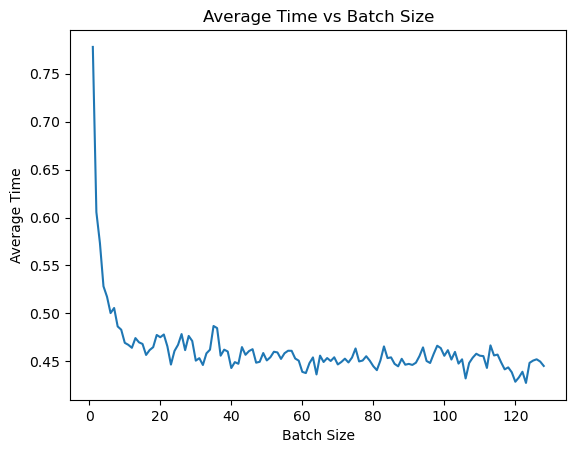

In [17]:
%matplotlib inline

# TODO plot for 2A

#plot time results vs batch size
plt.plot(batch_sizes, time_results_2a)
plt.xlabel('Batch Size')
plt.ylabel('Average Time')
plt.title('Average Time vs Batch Size')
plt.show()


In [18]:
# code for 2B

#estimate the startup costs

# For each experiment we know:
# total time = number of batches * (time per batch + startup cost per batch) (Equation for total running time)
# assuming that the time for completing a task in a batch is the same for all batches we can write:
# time per batch = time per task * batch size (Equation for time per batch)
# substituting the second equation into the first we get:
# total time = number of batches * (time per task * batch size + startup cost per batch)
# Distribute the right side:
# total time = number of batches * time per task * batch size + number of batches * startup cost per batch
# This equation has two unkonwns (1) time per task - one regression and (2) startup cost per batch, we fit a linear regression model to estimate these two unknowns

batch_sizes_np = np.array(batch_sizes)
number_of_batches_np = np.array([len(combos) / batch_size for batch_size in batch_sizes])
#make data matrix with first column as number of batches time batch size second column as number of batches
X_data = np.column_stack((number_of_batches_np * batch_sizes_np, number_of_batches_np))

y_data = np.array(time_results_2a)

#perform linear regression to solve for the coefficients
coefficients = np.linalg.lstsq(X_data, y_data, rcond=None)[0]

time_per_task = coefficients[0]
startup_cost = coefficients[1]

print('Time per task:', time_per_task)
print('Startup cost:', startup_cost)

Time per task: 0.00045358732859486576
Startup cost: 0.0003357705841255201


**TODO Answer for 2B**

3. Run the job with `prefer='threads'` and `prefer='processes'`. You do not need to vary batch size for this part. Which is more efficient?  Why? Consider our discussion of parallel threads in python.

In [19]:
# Code for 3

#Run with threads
time_result_threads = %timeit -o Parallel(n_jobs=4, prefer='threads')(delayed(r_sq_regression)(combo) for combo in combos)
print('Time with threads:', time_result_threads.average)

#Run with processes
time_result_processes = %timeit -o Parallel(n_jobs=4, prefer='processes')(delayed(r_sq_regression)(combo) for combo in combos)
print('Time with processes:', time_result_processes.average)

1.01 s ± 41.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Time with threads: 1.010570512144893
468 ms ± 13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Time with processes: 0.46811780385905877


**TODO Answer to 3**

Global interpreter lock prevents multiple threads from executing simultaneously. This is not the case with processes. Therefore, processes are more efficient than threads since they can run in parallel and do work concurrently.